# Markowitz Network using Transformer

In [1]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

## 데이터 준비
다우존스 지수를 활용  
2000년 이후 최신 데이터까지 포함, 해당 기간 중 데이터가 모두 존재하는 27개 기업 선별  
앞 4000개의 데이터 (~ 2015년 11월) 로 훈련  
이후 데이터를 통해 검증

In [2]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
symbols = tickers[1]['Symbol'].reset_index(drop=True).sort_values()
return_d = pdr.yahoo.daily.YahooDailyReader(symbols, start='JAN-01-2000')
df = return_d.read()['Adj Close']
return_d.close()

df = df.dropna(axis=1).pct_change()
df = df.dropna()
column = df.columns

In [3]:
df_train = df.iloc[:4000]
df_test = df.iloc[4000:]

In [4]:
df

Symbols,AAPL,AMGN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.088753,0.047867,-0.054135,-0.030166,0.033200,0.008752,-0.034632,0.021367,-0.062376,-0.051818,...,-0.035759,0.006512,-0.001606,-0.029004,-0.021677,-0.020408,0.011765,-0.026396,-0.023504,-0.033454
2000-01-04,-0.084310,-0.076465,-0.037758,-0.001556,-0.012853,-0.056102,0.000000,0.058578,-0.062987,-0.052732,...,-0.039735,-0.035121,-0.033781,-0.054546,-0.019242,-0.013258,-0.012791,-0.032325,-0.037199,-0.037418
2000-01-05,0.014633,0.034409,-0.025400,0.062306,0.023437,-0.003064,0.017938,0.041502,-0.046827,0.020243,...,0.028966,0.039272,0.010544,0.057693,-0.019025,-0.007677,-0.002356,0.033405,0.011364,-0.020408
2000-01-06,-0.086538,0.016632,0.020374,0.010264,0.050890,-0.016595,0.042584,-0.039848,0.042789,-0.047619,...,0.080429,0.008295,-0.033498,-0.005195,0.046060,0.019343,0.036600,-0.005080,-0.029214,0.010913
2000-01-07,0.047369,0.112475,0.014559,0.029028,0.032688,0.058750,0.017605,-0.015810,0.003800,0.058333,...,0.019851,0.095978,0.013068,0.000000,0.079954,0.039848,0.117312,-0.007384,0.025463,0.075564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-21,-0.012765,-0.005155,-0.013547,-0.040852,-0.011725,-0.024105,-0.011989,-0.069367,-0.012037,-0.001373,...,-0.005301,-0.009536,-0.018468,0.001541,0.003827,-0.015559,-0.003952,-0.004494,-0.012787,-0.007294
2022-01-24,-0.004864,-0.007202,0.001197,-0.006036,0.001121,0.003881,0.002127,0.000582,-0.001512,0.042137,...,0.000869,-0.014379,0.001149,0.021336,-0.008117,0.038251,0.002385,-0.003762,-0.002286,0.000071
2022-01-25,-0.011385,-0.004600,0.089222,-0.000490,-0.000093,-0.013884,0.042538,-0.006911,-0.005358,-0.013276,...,0.005498,0.007992,-0.026588,-0.003562,-0.010911,-0.001362,-0.011746,-0.001133,-0.026537,-0.021755


In [5]:
N_time = 60
N_future = 20
N_stock = 27
BATCH = 64

In [6]:
xc_train = np.zeros((4000-N_time-N_future, N_time, N_stock), np.float32)
xf_train = np.zeros((4000-N_time-N_future, N_future, N_stock), np.float32)

for i in range(N_time, 4000-N_future):
    xc_train[i-N_time] = df_train.iloc[i-N_time:i]
    xf_train[i-N_time] = df_train.iloc[i+1:i+1+N_future]
print(xc_train.shape)

(3920, 60, 27)


In [7]:
xc_test = np.zeros((len(df_test)-N_time-N_future, N_time, N_stock), np.float32)
xf_test = np.zeros((len(df_test)-N_time-N_future, N_future, N_stock), np.float32)

for i in range(N_time, len(df_test)-N_future):
    xc_test[i-N_time] = df_test.iloc[i-N_time:i]
    xf_test[i-N_time] = df_test.iloc[i+1:i+1+N_future]
print(xc_test.shape)

(1474, 60, 27)


In [8]:
xc_train = xc_train
xf_train = xf_train
xc_test = xc_test
xf_test = xf_test

GAMMA_CONST = 0.1
REG_CONST = 0.1
SAVE_MODEL = 'data/2-2.Markowitz_network_attn.h5'

## Markowitz Portfolio Theory  


In [9]:
def markowitz_objective(y_true, y_pred):
    W = y_pred
    xf_rtn = y_true
    W = tf.expand_dims(W, axis=1)
    R = tf.expand_dims(tf.reduce_mean(xf_rtn, axis=1), axis=2)
    C = tfp.stats.covariance(xf_rtn, sample_axis=1)
    
    rtn = tf.matmul(W, R)
    vol = tf.matmul(W, tf.matmul(C, tf.transpose(W, perm=[0, 2, 1])))*GAMMA_CONST
    reg = tf.reduce_sum(tf.square(W), axis=-1)*REG_CONST
    objective = rtn - vol - reg
    
    return -tf.reduce_mean(objective, axis=0)

#### Define Attention layer

In [10]:
def scaled_dot_product_attention(q, k, v, mask):
    '''
    q : query shape == (None, seq_len_q, depth)
    k : key shape == (None, seq_len_k, depth)
    v : value shape == (None, seq_len_v, depth_v)
    
    '''
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk/tf.math.sqrt(dk)
    # add mask
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    #softmax is normalized
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [11]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        '''
        split the last dimension into (num_heads, depth)
        transpose the result into (batch_size, num_heads, seq_len, depth)
        '''
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size=tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)   # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        return output, attention_weights

In [12]:
# check
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512)) # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
print(out.shape, attn.shape)

(1, 60, 512) (1, 8, 60, 60)


In [13]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [14]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask=False):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.d_model,
            "dff": self.dff,
            "rate": self.rate
        })
        return config

In [15]:
# check
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [16]:
xc_input = Input(batch_shape = (None, N_time, N_stock))
enc_output = EncoderLayer(d_model=N_stock, num_heads=3, dff=128, rate=0.3)(xc_input)
y_output = GlobalAveragePooling1D()(enc_output)
y_output = Activation('tanh')(y_output)

y_output = Activation('softmax')(y_output)

model = Model(xc_input, y_output)
model.compile(loss=markowitz_objective, optimizer=Adam(learning_rate=1e-5))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 27)]          0         
                                                                 
 encoder_layer_1 (EncoderLay  (None, 60, 27)           10199     
 er)                                                             
                                                                 
 global_average_pooling1d (G  (None, 27)               0         
 lobalAveragePooling1D)                                          
                                                                 
 activation (Activation)     (None, 27)                0         
                                                                 
 activation_1 (Activation)   (None, 27)                0         
                                                                 
Total params: 10,199
Trainable params: 10,199
Non-trainable p

In [17]:
times = 20
hist = model.fit(xc_train*times, xf_train*times, epochs=150, batch_size=BATCH,
                validation_data=(xc_test*times, xf_test*times))
config = model.get_config()
model.save(SAVE_MODEL)

Epoch 1/150
62/62 [==============================] - 2s 17ms/step - loss: -2.3448e-04 - val_loss: -0.0046
Epoch 2/150
62/62 [==============================] - 1s 9ms/step - loss: -2.8460e-04 - val_loss: -0.0046
Epoch 3/150
62/62 [==============================] - 1s 9ms/step - loss: -3.5275e-04 - val_loss: -0.0046
Epoch 4/150
62/62 [==============================] - 1s 9ms/step - loss: -4.1179e-04 - val_loss: -0.0046
Epoch 5/150
62/62 [==============================] - 1s 9ms/step - loss: -4.8430e-04 - val_loss: -0.0046
Epoch 6/150
62/62 [==============================] - 1s 9ms/step - loss: -5.5020e-04 - val_loss: -0.0047
Epoch 7/150
62/62 [==============================] - 1s 9ms/step - loss: -6.0027e-04 - val_loss: -0.0047
Epoch 8/150
62/62 [==============================] - 1s 9ms/step - loss: -6.6525e-04 - val_loss: -0.0047
Epoch 9/150
62/62 [==============================] - 1s 9ms/step - loss: -7.2825e-04 - val_loss: -0.0047
Epoch 10/150
62/62 [==============================] - 

Epoch 81/150
62/62 [==============================] - 1s 11ms/step - loss: -0.0025 - val_loss: -0.0051
Epoch 82/150
62/62 [==============================] - 1s 10ms/step - loss: -0.0025 - val_loss: -0.0051
Epoch 83/150
62/62 [==============================] - 1s 9ms/step - loss: -0.0025 - val_loss: -0.0051
Epoch 84/150
62/62 [==============================] - 1s 9ms/step - loss: -0.0025 - val_loss: -0.0051
Epoch 85/150
62/62 [==============================] - 1s 9ms/step - loss: -0.0025 - val_loss: -0.0051
Epoch 86/150
62/62 [==============================] - 1s 9ms/step - loss: -0.0026 - val_loss: -0.0051
Epoch 87/150
62/62 [==============================] - 1s 9ms/step - loss: -0.0026 - val_loss: -0.0051
Epoch 88/150
62/62 [==============================] - 1s 10ms/step - loss: -0.0026 - val_loss: -0.0051
Epoch 89/150
62/62 [==============================] - 1s 9ms/step - loss: -0.0026 - val_loss: -0.0051
Epoch 90/150
62/62 [==============================] - 1s 9ms/step - loss: -0.00

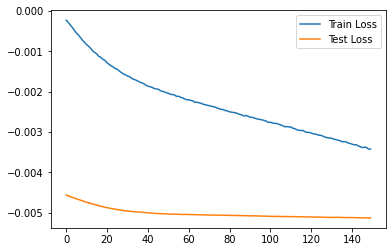

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 175ms/step


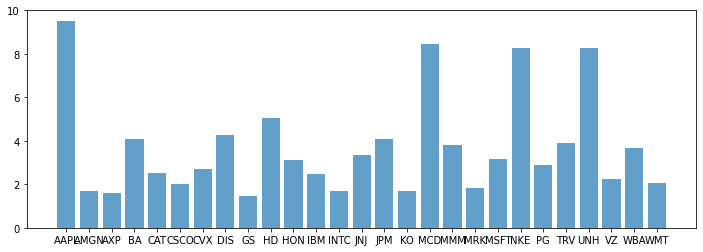

In [19]:
def check_w(n=0):
    plt.figure(figsize=(12,4))
    y_pred = model.predict(xc_test[n].reshape(1, N_time, N_stock))[0]
    plt.bar(column, y_pred*100, alpha=.7)
    plt.show()
check_w(0)

In [20]:
model = tf.keras.models.load_model(
    SAVE_MODEL, custom_objects={'EncoderLayer':EncoderLayer}, compile=False
)
model.compile(loss=markowitz_objective, optimizer=Adam(learning_rate=1e-5))

mpn_value = [10000]
crp_value = [10000]
w_crp = np.ones(N_stock)/N_stock

w_hist = []
for i in range(N_future, xc_test.shape[0], N_future):
    x = xc_test[i][np.newaxis, :, :] * 20.0
    w_prt = model.predict(x)[0]
    w_hist.append(w_prt)
    
    m_rtn = np.sum(xf_test[i], axis=0)
    
    mpn_value.append(mpn_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))
    
    xc_new = xc_test[i:(i+N_future), :, :]
    xf_new = xf_test[i:(i+N_future), :, :]
    
    idx = np.random.randint(0, xc_train.shape[0], 80)
    x = np.vstack([xc_new, xc_train[idx]])
    y = np.vstack([xf_new, xf_train[idx]])

    x *= 20.0
    y *= 20.0
    model.fit(x, y, epochs=50, batch_size=16, verbose=0)
    xc_train = np.vstack([xc_train, xc_new])
    xf_train = np.vstack([xf_train, xf_new])

1/1 [==============================] - 0s 17ms/step


In [21]:
test_date = []
for i in range(0, xc_test.shape[0], N_future):
    test_date.append(df_test.index[i])
print(len(test_date))

74


In [22]:
idx = np.arange(0, len(xc_test), N_future)

perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':mpn_value},
                       index=df_test.index[idx])

In [23]:
perf_df

,crp,markowitz
Date,,
2015-11-25,10000.000000,10000.000000
2015-12-24,10245.186359,10182.933807
2016-01-26,9921.119589,9819.832555
2016-02-24,10135.504842,10034.288101
2016-03-23,10663.688938,10529.095282
...,...,...
2021-05-21,26329.295582,31121.055842
2021-06-21,25919.147950,30603.859750
2021-07-20,27118.118428,32309.262823


In [27]:
round((perf_df.markowitz/perf_df.crp)[-1], 4)*100

120.15

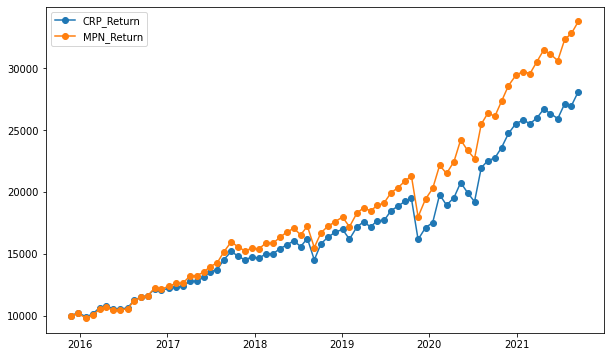

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(perf_df['crp'], 'o-', label='CRP_Return')
plt.plot(perf_df['markowitz'], 'o-', label='MPN_Return')
plt.legend()
plt.show()